In [1]:
import os
# os.environ["KERAS_BACKEND"] = "jax"

import gc
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

import tensorflow as tf
# import jax
import keras

from sklearn import metrics

from tqdm.notebook import tqdm

print(tf.__version__)
# print(jax.__version__)

2.16.1


In [2]:
def is_interactive():
    return 'runtime' in get_ipython().config.IPKernelApp.connection_file

print('Interactive?', is_interactive())

Interactive? True


In [3]:
SEED = 42
keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [3]:
# DATA = "/kaggle/input/leap-atmospheric-physics-ai-climsim"
DATA_NPY = "data"

In [5]:
sample = pl.read_csv('sample_submission.csv', n_rows=1)
TARGETS = sample.select(pl.exclude('sample_id')).columns
print(len(TARGETS))

368


In [6]:
BATCH_SIZE = 4096
train_files = [os.path.join(DATA_NPY, "split_%d.npy" % i) for i in range(1,100)]
valid_files = [os.path.join(DATA_NPY, "split_%d.npy" % i) for i in range(100, 102)]
train_options = tf.data.Options()
train_options.deterministic = True

def create_generator(file_paths):
    for file_path in file_paths:
        data = np.load(file_path, allow_pickle=True)
        for sample in data:
            yield (sample[:-368], sample[:-368]), sample[-368:]

def create_dataset_from_npy(file_paths, batch_size=BATCH_SIZE, shuffle_buffer_size=10000, is_training=True):
    dataset = tf.data.Dataset.from_generator(
        lambda: create_generator(file_paths),
        output_signature=(
            (tf.TensorSpec(shape=(556,), dtype=tf.float64), tf.TensorSpec(shape=(556,), dtype=tf.float64)), 
            tf.TensorSpec(shape=(368,), dtype=tf.float64)
        )
    )
    
    if is_training:
        dataset = dataset.shuffle(shuffle_buffer_size)
    
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

# Create train dataset
ds_train = create_dataset_from_npy(train_files, BATCH_SIZE, is_training=True)

# Create validation dataset
ds_valid = create_dataset_from_npy(valid_files, BATCH_SIZE, is_training=False)

In [7]:
norm_x = keras.layers.Normalization()
norm_x.adapt(ds_train.map(lambda x, y: x[0]).take(1000))

2024-06-15 21:38:00.089776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
norm_y = keras.layers.Normalization()
norm_y.adapt(ds_train.map(lambda x, y: y).take(1000))

mean_y = norm_y.mean
stdd_y =keras.ops.maximum(1e-10, norm_y.variance ** 0.5)

2024-06-15 21:43:45.156063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
mean_y = tf.cast(mean_y, tf.float64)
stdd_y = tf.cast(stdd_y, tf.float64)

In [10]:
min_y = np.min(np.stack([np.min(yb, 0) for _, yb in ds_train.take(1000)], 0), 0, keepdims=True)
max_y = np.max(np.stack([np.max(yb, 0) for _, yb in ds_train.take(1000)], 0), 0, keepdims=True)

2024-06-15 21:49:26.060567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-15 21:55:10.453753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
min_y = tf.cast(min_y, tf.float64)
max_y = tf.cast(max_y, tf.float64)

### Model definition & Training

In [12]:
@keras.saving.register_keras_serializable(package="MyMetrics", name="ClippedR2Score")
class ClippedR2Score(keras.metrics.Metric):
    def __init__(self, name='r2_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.base_metric = keras.metrics.R2Score(class_aggregation=None)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.base_metric.update_state(y_true, y_pred, sample_weight=None)
        
    def result(self):
        return keras.ops.mean(keras.ops.clip(self.base_metric.result(), 0.0, 1.0))
        
    def reset_states(self):
        self.base_metric.reset_states()

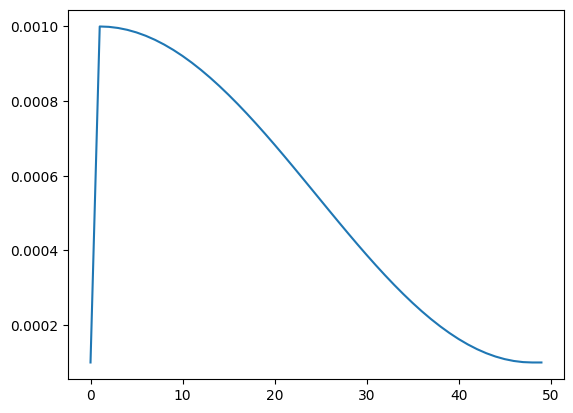

In [7]:
epochs = 50
learning_rate = 1e-3

epochs_warmup = 1
epochs_ending = 2
steps_per_epoch = int(np.ceil(len(train_files) * 100_000 / BATCH_SIZE))

lr_scheduler = tf.keras.optimizers.schedules.CosineDecay(
    1e-4,
    (epochs - epochs_warmup - epochs_ending) * steps_per_epoch, 
    warmup_target=learning_rate,
    warmup_steps=steps_per_epoch * epochs_warmup,
    alpha=0.1
)

In [14]:
import keras
import tensorflow as tf

keras.utils.clear_session()

def x_to_seq(x):
    x_seq0 = keras.ops.transpose(keras.ops.reshape(x[:, 0:60 * 6], (-1, 6, 60)), (0, 2, 1))
    x_seq1 = keras.ops.transpose(keras.ops.reshape(x[:, 60 * 6 + 16:60 * 9 + 16], (-1, 3, 60)), (0, 2, 1))
    x_flat = keras.ops.reshape(x[:, 60 * 6:60 * 6 + 16], (-1, 1, 16))
    x_flat = keras.ops.repeat(x_flat, 60, axis=1)
    return keras.ops.concatenate([x_seq0, x_seq1, x_flat], axis=-1)

def build_cnn(activation='relu'):    
    return keras.Sequential([
        keras.layers.Conv1D(512, 3, padding='same', activation=activation),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(256, 3, padding='same', activation=activation),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(128, 3, padding='same', activation=activation),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(164, 3, padding='same', activation=activation),
        keras.layers.BatchNormalization(),
    ])

# Current track
X_input = x = keras.layers.Input(shape=(556,), dtype=tf.float64)
x = keras.layers.Normalization(mean=norm_x.mean, variance=norm_x.variance)(x)
x = x_to_seq(x)

e = e0 = keras.layers.Conv1D(164, 1, padding='same')(x)
e = build_cnn()(e)
# Add global average to allow some communication between all levels even in a small CNN
e = e0 + e + keras.layers.GlobalAveragePooling1D(keepdims=True)(e)
e = keras.layers.BatchNormalization()(e)
e = e + build_cnn()(e)

p_all = keras.layers.Conv1D(14, 1, padding='same')(e)

p_seq = p_all[:, :, :6]
p_seq = keras.ops.transpose(p_seq, (0, 2, 1))
p_seq = keras.layers.Flatten()(p_seq)
assert p_seq.shape[-1] == 360

p_flat = p_all[:, :, 6:6 + 8]
p_flat = keras.ops.mean(p_flat, axis=1)
assert p_flat.shape[-1] == 8

P_current = keras.ops.concatenate([p_seq, p_flat], axis=1)

# Separate neural network track
nn_input = keras.layers.Input(shape=(556,), dtype=tf.float64)
nn = keras.layers.Dense(556*3, activation='relu')(nn_input)
nn = keras.layers.Dense(556*2, activation='relu')(nn)
nn = keras.layers.Dense(556, activation='relu')(nn)
P_nn = keras.layers.Dense(368, activation='linear')(nn)

# Combine both tracks
combined = keras.layers.concatenate([P_current, P_nn])

# Final layer
output = keras.layers.Dense(368, activation='linear')(combined)

# Build & compile
model = keras.Model(inputs=[X_input, nn_input], outputs=output)
model.compile(
    loss='mse', 
    optimizer=keras.optimizers.Adam(learning_rate),
    metrics=[ClippedR2Score()]
)

model.build(input_shape=[(None, 556), (None, 556)])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 556)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 556)       │          0 │ input_layer[0][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 360)       │          0 │ normalization[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 180)       │          0 │ normalization[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 16)        │          0 │ normalization[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 6, 60)     │          0 │ get_item[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 3, 60)     │          0 │ get_item_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 16)     │          0 │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose           │ (None, 60, 6)     │          0 │ reshape[0][0]     │
│ (Transpose)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_1         │ (None, 60, 3)     │          0 │ reshape_1[0][0]   │
│ (Transpose)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat (Repeat)     │ (None, 60, 16)    │          0 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 60, 25)    │          0 │ transpose[0][0],  │
│ (Concatenate)       │                   │            │ transpose_1[0][0… │
│                     │                   │            │ repeat[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 60, 164)   │      4,264 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 60, 164)   │    811,700 │ conv1d[0][0]      │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 60, 164)   │          0 │ conv1d[0][0],     │
│                     │                   │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1, 164)    │          0 │ sequential[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 60, 164)   │          0 │ add[0][0],        │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 164)   │        656 │ add_1[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 5,510,654 (21.02 MB)

 Trainable params: 5,506,086 (21.00 MB)

 Non-trainable params: 4,568 (17.84 KB)

In [15]:
# model_path = '/kaggle/input/leapseq2seq/model.keras'
# model = tf.keras.models.load_model(model_path)

In [16]:
ds_train_target_normalized = ds_train.map(lambda x, y: (x, (y - mean_y) / stdd_y))
ds_valid_target_normalized = ds_valid.map(lambda x, y: (x, (y - mean_y) / stdd_y))

history = model.fit(
    ds_train_target_normalized,
    validation_data=ds_valid_target_normalized,
    epochs=epochs,
    verbose=1 if is_interactive() else 2,
    callbacks=[
        keras.callbacks.ModelCheckpoint(filepath='models/dualmodel2.keras'),
        keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=2, verbose=1, monitor='val_r2_score', mode='max', min_lr=1e-6)
    ]
)

Epoch 1/30
   2440/Unknown 2452s 1s/step - loss: 12684.6406 - r2_score: 1.8599e-04

2024-06-15 22:36:02.432484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-15 22:36:02.432499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add/_140]]
/Users/johnny/anaconda3/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2465s 1s/step - loss: 12680.5312 - r2_score: 1.8591e-04 - val_loss: 0.8045 - val_r2_score: 0.0419 - learning_rate: 1.0000e-03
Epoch 2/30


2024-06-15 22:36:15.368509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-15 22:36:15.368525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape_1/_12]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.6965 - r2_score: 0.0830

2024-06-15 23:17:33.767941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-15 23:17:33.768076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_96/_100]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2491s 1s/step - loss: 0.6965 - r2_score: 0.0830 - val_loss: 0.6137 - val_r2_score: 0.1231 - learning_rate: 9.9684e-04
Epoch 3/30


2024-06-15 23:17:46.374561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-15 23:17:46.374583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape_1/_12]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.6388 - r2_score: 0.1285

2024-06-15 23:58:54.464191: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-15 23:58:54.464269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_96/_100]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2480s 1s/step - loss: 0.6388 - r2_score: 0.1285 - val_loss: 0.5845 - val_r2_score: 0.1519 - learning_rate: 9.8752e-04
Epoch 4/30


2024-06-15 23:59:06.774774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-15 23:59:06.774792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[functional_3_1/Cast/_2]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.6090 - r2_score: 0.1585

2024-06-16 00:40:21.731471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 00:40:21.731520: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_70/_102]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2488s 1s/step - loss: 0.6090 - r2_score: 0.1585 - val_loss: 0.5484 - val_r2_score: 0.1859 - learning_rate: 9.7218e-04
Epoch 5/30


2024-06-16 00:40:34.311907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 00:40:34.311925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[functional_3_1/Cast/_2]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.5672 - r2_score: 0.2006

2024-06-16 01:21:49.746752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 01:21:49.746774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_90/_124]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2488s 1s/step - loss: 0.5672 - r2_score: 0.2006 - val_loss: 0.5159 - val_r2_score: 0.2173 - learning_rate: 9.5101e-04
Epoch 6/30


2024-06-16 01:22:02.133509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 01:22:02.133526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[functional_3_1/Cast/_2]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.5068 - r2_score: 0.2611

2024-06-16 02:03:21.222289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 02:03:21.222313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_50/_176]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2492s 1s/step - loss: 0.5068 - r2_score: 0.2611 - val_loss: 0.4074 - val_r2_score: 0.3286 - learning_rate: 9.2432e-04
Epoch 7/30


2024-06-16 02:03:33.776072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 02:03:33.776091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape_1/_12]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.4139 - r2_score: 0.3538

2024-06-16 02:46:13.009282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 02:46:13.009338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_96/_100]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2572s 1s/step - loss: 0.4139 - r2_score: 0.3538 - val_loss: 0.3519 - val_r2_score: 0.3888 - learning_rate: 8.9247e-04
Epoch 8/30


2024-06-16 02:46:25.356800: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 02:46:25.356822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[functional_3_1/Cast/_2]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.3668 - r2_score: 0.4015

2024-06-16 03:29:10.364279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 03:29:10.364308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_90/_124]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2578s 1s/step - loss: 0.3668 - r2_score: 0.4015 - val_loss: 0.3317 - val_r2_score: 0.4096 - learning_rate: 8.5590e-04
Epoch 9/30


2024-06-16 03:29:22.951361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 03:29:22.951377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[functional_3_1/Cast/_2]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.3418 - r2_score: 0.4274

2024-06-16 04:12:04.323353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 04:12:04.323372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_22/_146]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2574s 1s/step - loss: 0.3418 - r2_score: 0.4274 - val_loss: 0.3111 - val_r2_score: 0.4318 - learning_rate: 8.1511e-04
Epoch 10/30


2024-06-16 04:12:16.747611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 04:12:16.747636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[functional_3_1/Cast/_2]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.3264 - r2_score: 0.4432

2024-06-16 04:54:59.386699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 04:54:59.386731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_96/_100]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2575s 1s/step - loss: 0.3264 - r2_score: 0.4432 - val_loss: 0.2993 - val_r2_score: 0.4448 - learning_rate: 7.7067e-04
Epoch 11/30


2024-06-16 04:55:11.916003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 04:55:11.916022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape_1/_12]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.3164 - r2_score: 0.4540

2024-06-16 05:37:50.728835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 05:37:50.728847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_62/_190]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2571s 1s/step - loss: 0.3164 - r2_score: 0.4540 - val_loss: 0.2965 - val_r2_score: 0.4477 - learning_rate: 7.2319e-04
Epoch 12/30


2024-06-16 05:38:03.095399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 05:38:03.095421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[functional_3_1/Cast/_2]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.3087 - r2_score: 0.4619

2024-06-16 06:20:43.583080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 06:20:43.583104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_70/_102]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2573s 1s/step - loss: 0.3087 - r2_score: 0.4619 - val_loss: 0.2854 - val_r2_score: 0.4609 - learning_rate: 6.7332e-04
Epoch 13/30


2024-06-16 06:20:55.964616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 06:20:55.964640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape_1/_12]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.3025 - r2_score: 0.4682

2024-06-16 07:03:36.335564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 07:03:36.335582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_60/_188]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2573s 1s/step - loss: 0.3025 - r2_score: 0.4682 - val_loss: 0.2783 - val_r2_score: 0.4676 - learning_rate: 6.2175e-04
Epoch 14/30


2024-06-16 07:03:48.730849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 07:03:48.730869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[functional_3_1/Cast/_2]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.2962 - r2_score: 0.4747

2024-06-16 07:46:23.521112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 07:46:23.521126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_32/_156]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2567s 1s/step - loss: 0.2962 - r2_score: 0.4747 - val_loss: 0.2744 - val_r2_score: 0.4725 - learning_rate: 5.6920e-04
Epoch 15/30


2024-06-16 07:46:36.080930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 07:46:36.080955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape_1/_12]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.2920 - r2_score: 0.4796

2024-06-16 08:29:16.316976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 08:29:16.316995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_76/_108]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2573s 1s/step - loss: 0.2920 - r2_score: 0.4796 - val_loss: 0.2733 - val_r2_score: 0.4745 - learning_rate: 5.1638e-04
Epoch 16/30


2024-06-16 08:29:28.713485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IsInf/_20]]
2024-06-16 08:29:28.713504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.2879 - r2_score: 0.4838

2024-06-16 09:12:03.144598: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 09:12:03.144619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add/_140]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2567s 1s/step - loss: 0.2879 - r2_score: 0.4838 - val_loss: 0.2686 - val_r2_score: 0.4810 - learning_rate: 4.6402e-04
Epoch 17/30


2024-06-16 09:12:15.581191: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 09:12:15.581214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[functional_3_1/Cast_1/_6]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.2846 - r2_score: 0.4875

2024-06-16 09:54:55.815501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 09:54:55.815641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_90/_124]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2573s 1s/step - loss: 0.2846 - r2_score: 0.4875 - val_loss: 0.2660 - val_r2_score: 0.4836 - learning_rate: 4.1285e-04
Epoch 18/30


2024-06-16 09:55:08.159813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 09:55:08.159832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[functional_3_1/Cast/_2]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.2814 - r2_score: 0.4909

2024-06-16 10:37:58.411010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 10:37:58.411025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_60/_188]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2583s 1s/step - loss: 0.2814 - r2_score: 0.4909 - val_loss: 0.2636 - val_r2_score: 0.4857 - learning_rate: 3.6356e-04
Epoch 19/30


2024-06-16 10:38:10.788723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 10:38:10.788748: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape_1/_12]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.2789 - r2_score: 0.4935

2024-06-16 11:20:52.160194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 11:20:52.160234: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_96/_100]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2574s 1s/step - loss: 0.2789 - r2_score: 0.4935 - val_loss: 0.2644 - val_r2_score: 0.4847 - learning_rate: 3.1685e-04
Epoch 20/30


2024-06-16 11:21:04.540068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 11:21:04.540102: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Size/_10]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.2770 - r2_score: 0.4958

2024-06-16 12:03:54.962672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 12:03:54.962736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_90/_124]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2583s 1s/step - loss: 0.2770 - r2_score: 0.4958 - val_loss: 0.2594 - val_r2_score: 0.4907 - learning_rate: 2.7335e-04
Epoch 21/30


2024-06-16 12:04:07.377372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 12:04:07.377387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[functional_3_1/Cast/_2]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.2744 - r2_score: 0.4987

2024-06-16 12:46:56.659221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 12:46:56.659308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_96/_100]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2582s 1s/step - loss: 0.2744 - r2_score: 0.4987 - val_loss: 0.2577 - val_r2_score: 0.4914 - learning_rate: 2.3366e-04
Epoch 22/30


2024-06-16 12:47:09.234431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 12:47:09.234448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[functional_3_1/Cast/_2]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.2724 - r2_score: 0.5007

2024-06-16 13:30:01.173328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 13:30:01.173343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_96/_100]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2585s 1s/step - loss: 0.2724 - r2_score: 0.5007 - val_loss: 0.2561 - val_r2_score: 0.4942 - learning_rate: 1.9834e-04
Epoch 23/30


2024-06-16 13:30:13.803394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 13:30:13.803411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[functional_3_1/Cast/_2]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.2710 - r2_score: 0.5024

2024-06-16 14:12:52.226777: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 14:12:52.226807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_90/_124]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2571s 1s/step - loss: 0.2710 - r2_score: 0.5024 - val_loss: 0.2534 - val_r2_score: 0.4971 - learning_rate: 1.6786e-04
Epoch 24/30


2024-06-16 14:13:04.589350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 14:13:04.589373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[functional_3_1/Cast/_2]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.2695 - r2_score: 0.5041

2024-06-16 14:55:57.040614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 14:55:57.040698: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_96/_100]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2585s 1s/step - loss: 0.2695 - r2_score: 0.5041 - val_loss: 0.2536 - val_r2_score: 0.4972 - learning_rate: 1.4264e-04
Epoch 25/30


2024-06-16 14:56:09.703957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 14:56:09.703975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape_1/_12]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.2684 - r2_score: 0.5053

2024-06-16 15:39:06.480217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 15:39:06.480241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_90/_124]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2589s 1s/step - loss: 0.2684 - r2_score: 0.5053 - val_loss: 0.2514 - val_r2_score: 0.4993 - learning_rate: 1.2304e-04
Epoch 26/30


2024-06-16 15:39:18.821918: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 15:39:18.821933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[functional_3_1/Cast/_2]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.2674 - r2_score: 0.5065

2024-06-16 16:22:20.973701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 16:22:20.973736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_92/_126]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2594s 1s/step - loss: 0.2674 - r2_score: 0.5065 - val_loss: 0.2506 - val_r2_score: 0.5001 - learning_rate: 1.0932e-04
Epoch 27/30


2024-06-16 16:22:33.291165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 16:22:33.291181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[functional_3_1/Cast/_2]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.2666 - r2_score: 0.5074

2024-06-16 17:05:26.775886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 17:05:26.775915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_90/_124]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2586s 1s/step - loss: 0.2666 - r2_score: 0.5074 - val_loss: 0.2504 - val_r2_score: 0.5003 - learning_rate: 1.0168e-04
Epoch 28/30


2024-06-16 17:05:39.373303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 17:05:39.373319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[functional_3_1/Cast/_2]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.2659 - r2_score: 0.5082

2024-06-16 17:48:47.416439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 17:48:47.416492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_90/_124]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2601s 1s/step - loss: 0.2659 - r2_score: 0.5082 - val_loss: 0.2495 - val_r2_score: 0.5016 - learning_rate: 1.0000e-04
Epoch 29/30


2024-06-16 17:49:00.087269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 17:49:00.087292: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[functional_3_1/Cast/_2]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.2654 - r2_score: 0.5086

2024-06-16 18:32:53.378255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 18:32:53.378294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_90/_124]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2647s 1s/step - loss: 0.2654 - r2_score: 0.5086 - val_loss: 0.2508 - val_r2_score: 0.4998 - learning_rate: 1.0000e-04
Epoch 30/30


2024-06-16 18:33:06.801686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 18:33:06.801699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[functional_3_1/Cast/_2]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.2649 - r2_score: 0.5093

2024-06-16 19:17:15.529108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 19:17:15.529143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_92/_126]]


2440/2440 ━━━━━━━━━━━━━━━━━━━━ 2661s 1s/step - loss: 0.2649 - r2_score: 0.5093 - val_loss: 0.2491 - val_r2_score: 0.5017 - learning_rate: 1.0000e-04


2024-06-16 19:17:28.273107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-16 19:17:28.273125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[functional_3_1/Cast/_2]]


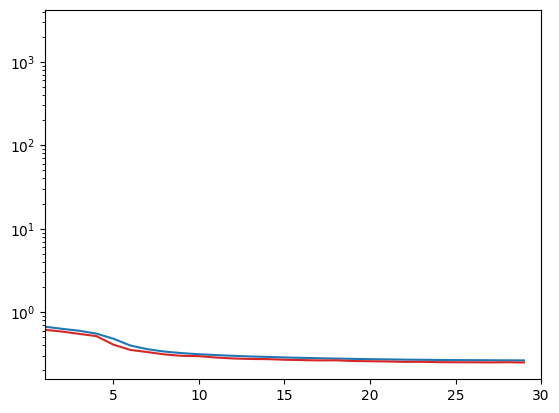

In [17]:
plt.plot(history.history['loss'], color='tab:blue')
plt.plot(history.history['val_loss'], color='tab:red')
plt.xlim(1, epochs)
plt.yscale('log');

In [18]:
y_valid = np.concatenate([yb for _, yb in ds_valid])
p_valid = model.predict(ds_valid, batch_size=BATCH_SIZE) * stdd_y + mean_y

2024-06-16 19:17:36.635798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 358ms/step


2024-06-16 19:17:46.444645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/johnny/anaconda3/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [19]:
p_valid.numpy()[0]

array([ 4.68271076e-05,  6.54859208e-06,  4.85240315e-05,  1.04575281e-04,
        1.06116023e-04,  1.42012307e-04,  1.31266701e-04,  1.12124755e-04,
        7.48324094e-05,  5.30711440e-05,  3.82177126e-05,  2.98134320e-05,
        2.39097246e-05,  1.88137067e-05,  1.31679518e-05,  8.30622144e-06,
        5.09087711e-06,  4.73232806e-06,  2.93335960e-06,  2.61567244e-06,
        3.35546852e-06, -2.55085802e-07, -7.18472753e-07,  3.06081771e-06,
        9.14753679e-06,  1.48243898e-05,  1.14206239e-05,  4.11803053e-06,
        3.59923137e-06,  3.97512728e-06, -7.01202458e-07, -1.74745620e-06,
        6.83330488e-07, -1.16697272e-05, -1.18309926e-05,  5.89188624e-05,
        1.01812385e-04,  8.30782536e-05,  7.49280335e-05,  7.87301990e-05,
        3.41467193e-05, -6.76596463e-07, -1.09981402e-05, -2.17474825e-05,
       -2.96528900e-05, -3.17152638e-05, -3.08222170e-05, -2.16980042e-05,
       -2.18282175e-05, -1.90613213e-05, -1.75718145e-05, -1.85329718e-05,
       -2.53623649e-05, -

In [20]:
scores_valid = np.array([metrics.r2_score(y_valid[:, i], p_valid[:, i]) for i in range(len(TARGETS))])
plt.plot(scores_valid.clip(-1, 1))

ValueError: Input arrays use different devices: cpu, /job:localhost/replica:0/task:0/device:CPU:0

In [ ]:
mask = scores_valid <= 1e-3
f"Number of under-performing targets: {sum(mask)}"

In [ ]:
f"Clipped score: {scores_valid.clip(0, 1).mean()}"

In [ ]:
del y_valid, p_valid
gc.collect();